<a href="https://colab.research.google.com/github/GitWahome/Simulation-and-Modelling/blob/master/TrafficSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import matplotlib.pyplot as plt
import numpy as np


class traffic_simulation():

    def __init__(self, number_of_lanes, road_length, density, max_speed, Mod, start_random, log, switch, speed_variation):
        self.number_of_lanes = number_of_lanes
        self.road_length = road_length
        self.density = density
        self.max_speed = max_speed
        self.Mod = Mod
        self.car_count = []
        self.start_random = start_random
        self.log = log
        self.switch = switch
        self.flow_cells = 0
        self.flow_rate = 0
        self.speed_variation = speed_variation

    def add_cars(self):
        number_of_cars = int(self.road_length * self.number_of_lanes * self.density)
        # STEP 1: GENERATE NUMBER OF CARS PER LANE
        # Used a mulinomial distribution of fixed sum
        cars_per_lane = \
        np.random.multinomial(number_of_cars, np.ones(self.number_of_lanes) / self.number_of_lanes, size=1)[0]
        return cars_per_lane

    def car_count_track(self):
        """
        While I could mitigate these by performing the update equation right to left so I am aware of the next car first before moving
        the current one, I oughted to let accidents happen to reflect human error. At each stage, we do an accident count. In each accident, the car
        That was already in that position is removed by the current moving one. We can find this by counting the number of cars in the lane and comparing it
        to the last count of cars we saw
        I will visualize this and we can tell how many cars went out at each instance by checking the change
        """
        x = [int(x) for x in range(len(self.car_count))]
        y = self.car_count
        plt.scatter(x, y)
        plt.xlabel("Simulation Number")
        plt.ylabel("Number of vehicles")
        
    def move_cars(self, all_lanes):

        # Updated Lanes token
        updated_all_lanes = []
        all_lanes_count = 0

        # Indices and position for switch lane cars
        switch_lane_velocity, switch_lane_index = [], []

        # Step 1: Get Car Positions for each Lane
        lane_car_positions = []
        for lane in all_lanes:
            lane_profile = {}
            for car in range(len(lane)):
                if lane[car] is not '.':
                    lane_profile[car] = lane[car]
                    # Set car count for accident count
            lane_car_positions.append(lane_profile)

        # Move the car 1 position ahead depending on the velocity
        # Add 1 if the next car is more more than v steps ahead
        # If at max speed keep constant
        # If the next car is too near reduce speed by 1

        for lane in range(len(lane_car_positions)):

            car_positions_keys = list(lane_car_positions[lane].keys())
            lane_car_count = 0

            # Generate an empty lane. Updated positions and velocities will be pushed into this.
            updated_lane = ['.'] * self.road_length
            sorted_lane = sorted(list(car_positions_keys))

            # In case of multilane, we want some cars to be pushed to the adjascent lane
            # We have a list tracking vehicles that can cause collision. These and their next position are saved in a switch lane list.
            # The idea is, cars incoming are given driving priority. If the switch cannot happen, the car approaching switches or causes an accident thus disappearing.
            # These are eliminated from the highway.

            # We start the lane switch after the first lane is scanned. Otherwise it stays in lane.
            if lane > 0 and lane < self.number_of_lanes:
                for position in range(len(switch_lane_index)):
                    updated_lane[switch_lane_index[position]] = switch_lane_velocity[position]

            for cars in range(len(sorted_lane)):

                # Get current car velocity and indices for easy comparison
                current_index = car_positions_keys[cars % len(car_positions_keys)] % self.road_length
                current_car_velocity = int(lane_car_positions[lane][sorted_lane[cars % len(sorted_lane)]])
                next_index = car_positions_keys[(cars + 1) % len(car_positions_keys)] % self.road_length
                next_car_velocity = lane_car_positions[lane][sorted_lane[(cars + 1) % len(sorted_lane)]]
                
                # Define_new_velocities

                space = (((next_index - current_index) % self.road_length)) - 1

                if self.log:
                    print(
                        f"Current Ind: {current_index} --> Next_ind = {next_index} New Ind:{new_index} Current Vel: {current_car_velocity} --> Next Vel {next_car_velocity}, Space --> {space}")

                # Model logic for when updates happened
                # if the next position will not have or jump over the next car, we can move, otherwise we will switch lanes

                # Model for normal road flow: In case the next car is not past the edge
                # Set next_velocity
                if space == 0:
                    next_velocity = 0
                    new_index = next_index - 1
                # If there is space greater than our velocity and our velocity velocity is less than max speed, accelerate by 1:

                if space > current_car_velocity and current_car_velocity < self.max_speed:
                    
                    if not self.speed_variation:
                      next_velocity = current_car_velocity + 1
                    else:
                      next_velocity = random.randint(1, self.max_speed)
                    new_index = (current_index + next_velocity) % self.road_length

                # If there is not space equal or greater than velocity but space nonetheless, we could either decelerate by 1 or to space depending on how mod allows
                elif space < current_car_velocity and space > 0:
                    # This model will retain all Its cars
                    if self.Mod:
                        next_velocity = 0
                        # Stop just before the next car
                        new_index = next_index - 1

                    # If lane switch is off Next index might lead to an accident.
                    # It all depends on whether the side lane has space for the car.
                    # Some vehicles can will survive after the switch though

                    # Lookback: Check if one can switch. We can only switch to the right

                    elif self.switch and lane < self.number_of_lanes - 1 and all_lanes[lane + 1][
                        (current_index + current_car_velocity) % self.road_length] == '.':
                        if not self.speed_variation:
                          next_velocity = current_car_velocity
                        else:
                          next_velocity = random.randint(1, self.max_speed)
                          
                        new_index = (current_index + next_velocity) % self.road_length
                        switch_lane_velocity.append(next_velocity)
                        switch_lane_index.append(new_index)

                    # Lookback Fails: Slow down to stop then move when space build.
                    # This could cause traffic, but thats the fun I guess.
                    else:
                        next_velocity = 0
                        new_index = current_index + space

                # if speed is maximum and their is space, keep moving
                elif current_car_velocity == self.max_speed and space > self.max_speed:
                    if not self.speed_variation:
                      next_velocity = current_car_velocity
                    else:
                      next_velocity = random.randint(1, self.max_speed)
                      
                    new_index = (current_index + next_velocity) % self.road_length

                # If switch cannot happen, let jam_continue. This is the lookback if we have 0 space
                elif self.switch and lane < self.number_of_lanes - 1:
                    if not self.speed_variation:
                      next_velocity = current_car_velocity + 1
                    else:
                      next_velocity = random.randint(1, self.max_speed)
                    new_index = current_index + 1
                    if self.switch:
                        switch_lane_velocity.append(next_velocity)
                        switch_lane_index.append(new_index)

                    next_velocity = '.'
                elif lane < self.number_of_lanes - 1:
                    next_velocity = min([space, current_index])
                    new_index = current_index + 1
                else:
                    next_velocity = 0
                    new_index = current_index

                lane_car_count += 1

                # Now generate a new lane with the new car positions with their velocity at the index
                # Insert cars with their next velocities to new index on the updated lane template
                # TODO: For multilane, if the next position has a car, look at next lane. If that too has a car, look at next, if they all do, #STOP CAR.
                updated_lane[new_index % self.road_length] = next_velocity

            all_lanes_count += lane_car_count
            # Add this to an all_lane like token for visualization.
            updated_all_lanes.append(updated_lane)

        self.car_count.append(all_lanes_count)
        return updated_all_lanes

    def show_lanes(self, all_lanes):
        for lane in all_lanes:
            print(''.join([str(x) for x in lane]))
        return None

    def lanes(self):
        # Generate Lanes Car Profiles
        initial_cars_per_lane = self.add_cars()
        all_lanes = []
        for ln in range(self.number_of_lanes):
            # Random start velocities
            if self.start_random:
                car_velocities = [str(random.randint(0, self.max_speed)) for s in range(initial_cars_per_lane[ln])]
            else:
                car_velocities = [str(0) for s in range(initial_cars_per_lane[ln])]
            lane = car_velocities + ['.' for i in range((self.road_length - initial_cars_per_lane[ln]))]

            random.shuffle(lane)
            all_lanes.append(lane)

        return all_lanes

    def simulate(self, num_times, spacer, plot):
        # Initiate a lane populated with cars
        all_lanes = self.lanes()

        # Move cars during simulation
        for sims in range(num_times):
            if spacer:
                print(u'\u25A0' * (self.road_length))
            if plot:
              self.show_lanes(all_lanes)
            all_lanes = self.move_cars(all_lanes)
            self.flow_cells += sum([int(value[0]) for value in all_lanes if value[0] != '.'])

        self.flow_rate = (self.flow_cells / float(num_times)) / float(self.number_of_lanes)
        if plot:
          self.car_count_track()



DENSITY: 0.1
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
....................3................3............
0....2.5......4........4.......1....5...........1.
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
........................4................4........
.1....0.....5......5........5....2.......5......0.
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
.............................5................5...
...2...1.........5......5.......0...3.........5..1
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
.5................................5...............
.2....3..2............5......5...1......4.......0.
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
......5................................5..........
....3...0...3..............5....0..2.........5...1
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
...........5................................5.....
.2..0....1......4..............0.1....3.........0.
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
................5.

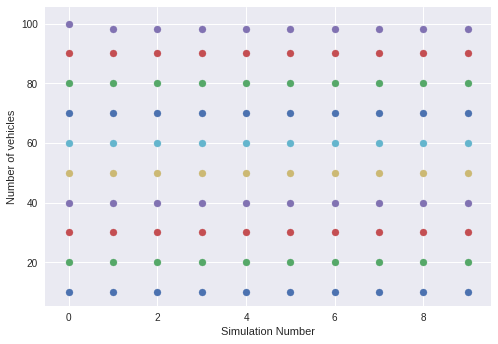

In [0]:
for den in range(1,11):
    print(f"DENSITY: {den/10.0}")
    
    traffic_1 = traffic_simulation(number_of_lanes=2, road_length=50, density=den/10.0, max_speed=5, Mod=False, 
                                     start_random=True, log=False, switch=False, speed_variation = False)
    traffic_1.simulate(num_times=10, spacer=True, plot = True)
    
    print(u'\u25A0' * (traffic_1.road_length))
    print("\n")

In [0]:
for i in range(100):
  flow_by_density = []
  for den in range(1,11):
    sim_ds = []  
    for i in range(10):
      traffic_1 = traffic_simulation(number_of_lanes=1, road_length=50, density=den/10.0, max_speed=10, Mod=False, 
                                     start_random=True, log=False, switch=False, speed_variation = False)
      traffic_1.simulate(num_times=20, spacer=False, plot = False)
      sim_ds.append(traffic_1.flow_rate)
    flow_by_density.append(np.average(sim_ds))


  plt.scatter([de/10.0 for de in range(10)], flow_by_density)
  
plt.xlabel("Vehicle Density")
plt.ylabel("Flow rate")
plt.title("Density by flow rate")
plt.show()

In [0]:
for i in range(100):
  flow_by_density = []
  for den in range(1,11):
    sim_ds = []  
    for i in range(10):
      traffic_1 = traffic_simulation(number_of_lanes=2, road_length=50, density=den/10.0, max_speed=5, Mod=False, 
                                     start_random=True, log=False, switch=False, speed_variation = False)
      traffic_1.simulate(num_times=10, spacer=False, plot = False)
      sim_ds.append(traffic_1.flow_rate)
    flow_by_density.append(np.average(sim_ds))


  plt.scatter([de/10.0 for de in range(10)], flow_by_density)
  
plt.xlabel("Vehicle Density")
plt.ylabel("Flow rate")
plt.title("Density by flow rate")
plt.show()